# Figure 2 - Cheese3D jitter analysis

This notebook contains the code to reproduce Figure 2a-f.

To run this notebook, you need the following data:
1. Anipose project: `20231013-long-anes-rig2`
2. Anipose project: `20240919_long-anes-clips_rig2`
3. Facemap project: `20240919_long-anes-clips_rig2`

## Prepare libraries and first dataset

In [1]:
%load_ext autoreload
%autoreload 2

# Update path as if notebook was run from top-level repo directory
import os
import sys

pwd = %pwd
if pwd.endswith('notebooks'):
    sys.path.insert(0, os.path.abspath('..'))
    new_pwd = os.path.abspath(f"{pwd}/..")
    %cd {new_pwd}

/home/houlab/repos/mouse-fe-analysis


/home/houlab/micromamba/envs/mouse-fe-analysis/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from pathlib import Path
from functools import reduce
from scipy.stats import pearsonr, ttest_rel, wilcoxon

from fepipeline.features.landmarks import read_3d_data
from fepipeline.anatomy import compute_measurements_df
from labutils.plotting import (sns_setup,
                               landmark_cmap,
                               measurements_cmap,
                               save_figure)
from labutils.utils import maybe

sns_setup()
OUTPUT_DIR = "./figures/Figure2-Feb2025"
os.makedirs(OUTPUT_DIR, exist_ok=True)

STILL_PERIODS = {     # Note these times correspond to the clips from the original length videos
    "B6": (38.50, 44.05),
    "B8": (34.30, 39.55),
    "B15": (27.20, 34.15),
    "B20": (34.55, 41.00),
    "B26": (58.20, 63.28),
}

REGION_ORDER = ["eye(left)", "eye(right)",
                "ear(left)", "ear(right)",
                "nose", "whisker pad", "mouth"]

_, LANDMARK_CMAP = landmark_cmap()
_, MEASUREMENT_CMAP = measurements_cmap()

DATA_CACHE = "measurements-data-cache" 
os.makedirs(DATA_CACHE, exist_ok=True)
COORD_DATA_CACHE = os.sep.join([DATA_CACHE, "long-anes-jitter-coords.pkl"])
MEAS_DATA_CACHE = os.sep.join([DATA_CACHE, "long-anes-jitter-meas.pkl"])

ANIPOSE_BASE = 'anipose-projects/20231013-long-anes-rig2'
COORDINATE_PATHS = {}
key_cols = ('mouse', 'source', 'condition')
for p in Path(ANIPOSE_BASE).glob('*/pose-3d/*.csv'):
    mouse = p.name.split('_')[1]
    source = 'rig2'
    condition = 'awake' if 'awake' in p.name else 'anes'
    if condition == "awake":
        continue
    COORDINATE_PATHS[(mouse, source, condition)] = p
data_keys = list(COORDINATE_PATHS.keys())
data_keys

[('B26', 'rig2', 'anes'),
 ('B20', 'rig2', 'anes'),
 ('B15', 'rig2', 'anes'),
 ('B8', 'rig2', 'anes'),
 ('B6', 'rig2', 'anes')]

In [3]:
coord_data = {k: read_3d_data(v.parent.parent.as_posix())
              for k, v in COORDINATE_PATHS.items()}

meas_df = compute_measurements_df(coord_data)
meas_df

,mouse,source,condition,measurement_group,measurement_name,measurement_units,measurement_type,measurement_value,std,count,timeseries
42,B15,rig2,anes,ear,ear-width-left,mm,distance,7.040880,0.228273,453719,"[6.822283208000382, 6.825869186184623, 6.82857..."
35,B15,rig2,anes,eye,eye-height-right,mm,distance,2.797457,0.074105,453719,"[2.7929924915113395, 2.7961283489633235, 2.798..."
36,B15,rig2,anes,eye,eye-width-left,mm,distance,3.882966,0.051499,453719,"[3.848385687970088, 3.8424846024975143, 3.8370..."
37,B15,rig2,anes,eye,eye-width-right,mm,distance,3.901731,0.048142,453719,"[3.7860065073015265, 3.7871578183900425, 3.788..."
38,B15,rig2,anes,eye,eye-area-left,mm^2,area,8.580178,0.371415,453719,"[8.47063095756957, 8.454253057440598, 8.438011..."
...,...,...,...,...,...,...,...,...,...,...,...
63,B8,rig2,anes,ear,ear-area-left,mm^2,area,75.783488,1.261482,396570,"[77.57683130382541, 77.61146656434293, 77.6453..."
64,B8,rig2,anes,ear,ear-area-right,mm^2,area,78.494843,0.868175,396570,"[79.15804354957348, 79.23161238944319, 79.2941..."
65,B8,rig2,anes,mouth,mouth-area,mm^2,area,1.747887,0.078828,396570,"[1.8803684253954824, 1.8789482156667694, 1.876..."
66,B8,rig2,anes,nose,nose-bulge-volume,mm^3,volume,8.171932,0.140048,396570,"[8.284290202802397, 8.270171295488188, 8.25633..."


In [4]:
def build_jitter_df(coord_data, periods):
    jitter_df = []
    for mouse, period in periods.items():
        start = round(period[0] * 60 * 100) if period[0] is not None else None
        end = round(period[1] * 60 * 100) if period[1] is not None else None
        if (mouse, "rig2", "anes") in coord_data:
            positions = coord_data[(mouse, "rig2", "anes")]
        else:
            positions = coord_data[(mouse, "rig2", "dead")]
        for name, timeseries in positions.items():
            if "eye" in name:
                if "left" in name:
                    group = "eye(left)"
                else:
                    group = "eye(right)"
            elif "ear" in name:
                if "left" in name:
                    group = "ear(left)"
                else:
                    group = "ear(right)"
            elif "lip" in name:
                group = "mouth"
            elif "nose" in name:
                group = "nose"
            elif "pad" in name:
                group = "whisker pad"
            elif "ref" in name:
                continue
            else:
                raise ValueError(f"Cannot map {name} to landmark group.")
            for i, coord in enumerate(("x", "y", "z")):
                xs = timeseries[start:end, i]
                vs = np.abs(np.diff(xs)) * 100
                dev = (xs - np.mean(xs)) * 1000
                jitter_df.append([mouse, group, name, coord, xs, vs, dev,
                                  np.std(xs) * 1000, np.min(dev), np.max(dev),
                                  np.mean(vs), np.min(vs), np.max(vs)])
            # 3d deviations
            xs = timeseries[start:end]
            vs = np.linalg.norm(np.diff(xs, axis=0), axis=-1) * 100
            dev = np.linalg.norm(xs - np.mean(xs, axis=0), axis=-1) * 1000
            jitter_df.append([mouse, group, name, "vector", xs, vs, dev,
                              np.std(dev), np.min(dev), np.max(dev),
                              np.mean(vs), np.min(vs), np.max(vs)])

    jitter_df = pd.DataFrame(jitter_df, columns=["mouse",
                                                 "region",
                                                 "landmark",
                                                 "coordinate",
                                                 "positions",
                                                 "velocities",
                                                 "deviations",
                                                 "position_stddev",
                                                 "min_deviation",
                                                 "max_deviation",
                                                 "velocity_mean",
                                                 "min_velocity",
                                                 "max_velocity"])

    return jitter_df

jitter_df = build_jitter_df(coord_data, STILL_PERIODS)
jitter_df

,mouse,region,landmark,coordinate,positions,velocities,deviations,position_stddev,min_deviation,max_deviation,velocity_mean,min_velocity,max_velocity
0,B6,ear(left),ear(base)(left),x,"[-10.978894849671976, -10.97889988630729, -10....","[0.0005036635315036619, 0.03213321783022138, 0...","[-8.881936120113565, -8.886972755428602, -8.56...",10.190951,-34.841774,38.596775,0.084228,1.349499e-06,0.449446
1,B6,ear(left),ear(base)(left),y,"[8.608205660529535, 8.610690259066445, 8.61297...","[0.24845985369097434, 0.22890685015539702, 0.1...","[10.330301771697137, 12.81490030860688, 15.103...",9.884115,-37.488798,31.603403,0.103464,3.583072e-06,0.617869
2,B6,ear(left),ear(base)(left),z,"[13.296649446659792, 13.296686278218402, 13.29...","[0.0036831558610117554, 0.009500932510775328, ...","[-2.8891803155950413, -2.8523487569849237, -2....",8.172302,-31.122093,34.666823,0.076473,7.829470e-07,0.456464
3,B6,ear(left),ear(base)(left),vector,"[[-10.978894849671976, 8.608205660529535, 13.2...","[0.24848766208846237, 0.2313464014303316, 0.20...","[13.926639466574342, 15.85357524682009, 17.581...",6.506876,0.515757,41.350138,0.176313,1.929839e-03,0.627349
4,B6,ear(right),ear(base)(right),x,"[11.782877003413082, 11.785238583673546, 11.78...","[0.236158026046418, 0.21312380560551958, 0.184...","[-16.802087399483412, -14.440507139019232, -12...",18.399867,-84.423994,67.585417,0.154551,9.356498e-08,0.982830
...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,B26,mouth,upperlip(left),vector,"[[-1.9379050105137807, -5.09813185550081, 21.4...","[0.08321917573870498, 0.06488009153900923, 0.0...","[11.7789990003664, 12.16399894019403, 12.44205...",13.091409,0.597046,141.608559,0.144948,3.030276e-03,0.973767
536,B26,mouth,upperlip(right),x,"[2.3467340004792563, 2.3456967546873977, 2.344...","[0.10372457918585987, 0.10040595188018919, 0.0...","[1.022696875515372, -0.014548916343226637, -1....",7.200103,-24.829219,26.693768,0.046576,1.921015e-06,0.260156
537,B26,mouth,upperlip(right),y,"[-5.224003676692099, -5.223853480757391, -5.22...","[0.015019593470810833, 0.014928468814900953, 0...","[2.445984694730008, 2.5961806294381162, 2.7454...",15.749506,-60.368896,45.219034,0.046247,2.519496e-06,0.477975
538,B26,mouth,upperlip(right),z,"[21.229670252932152, 21.229979191181677, 21.23...","[0.030893824952471505, 0.02055208448403789, 0....","[11.876217928037391, 12.185156177562106, 12.39...",8.211574,-33.148845,26.538244,0.036414,1.531794e-06,0.277028


In [5]:
# check for deviations larger than 50 microns
jitter_df.query("position_stddev > 50")

,mouse,region,landmark,coordinate,positions,velocities,deviations,position_stddev,min_deviation,max_deviation,velocity_mean,min_velocity,max_velocity


## Figure a

(code from 2024-04-05-long-anes-jitter.ipynb)

Distribution of keypoint-specific jitter (frame-to-frame velocity) during a motionless period for an example mouse.

Each subpanel indicates a different facial region, and each curve indicates a different keypoint.

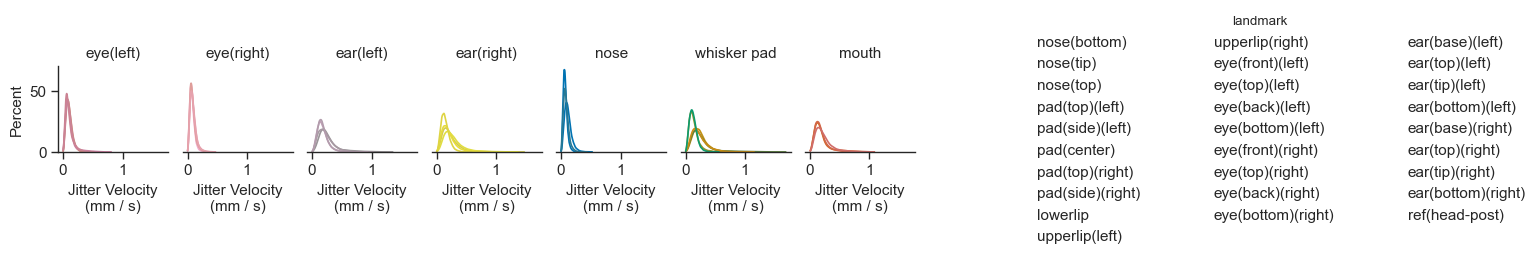

In [6]:
def plot_histogram(deviations, color, label):
    sns.histplot(x=np.concatenate(deviations.values, axis=0),
                 color=LANDMARK_CMAP[label],
                 label=label,
                 kde=True,
                 stat="percent",
                 binwidth=0.05,
                 # hack to hide bars but keep percent y-axis
                 fill=False,
                 linewidth=0)
    # sns.kdeplot(x=np.concatenate(deviations.values, axis=0),
    #             color=LANDMARK_CMAP[label],
    #             label=label)

ncols = len(jitter_df["region"].unique())
total_width = 2 * 5 # inches
facet_width = total_width / ncols
total_height = 2
aspect = facet_width / total_height
g = sns.FacetGrid(jitter_df.query("mouse == 'B15' & coordinate =='vector'"),
                  col="region", hue="landmark",
                  col_order=REGION_ORDER,
                #   col_wrap=2,
                #   xlim=(-100, 100),
                #   ylim=(0, 2),
                  height=total_height,
                  aspect=aspect,
                #   subplot_kws={"width": 0.5},
                  margin_titles=True)
g.map(plot_histogram, "velocities")
g.add_legend(label_order=list(LANDMARK_CMAP.keys()), ncols=3)
# g.figure.suptitle("Coordinate-wise Deviation from Mean Landmark Position")
g.set_xlabels("Jitter Velocity\n(mm / s)")
g.set_titles(col_template="{col_name}")
g.tight_layout(w_pad=0.5)
for ax in g.axes.flat[1:]:
    sns.despine(ax=ax, left=True)
    ax.tick_params(axis="y", left=False)

fname = "a-long-anes-jitter-hist"
path = os.sep.join([OUTPUT_DIR, f"{fname}.svg"])
g.savefig(path, bbox_inches="tight")

## Figure b

(code from 2024-04-05-long-anes-jitter.ipynb)

Summary of keypoint-specific jitter across mice (n= 5), where each column group indicates a facial region and
each column indicates a keypoint.

### functions

In [7]:
def sort_by_region(df, region_order, *columns):
    df.loc[:, "region_rank"] = df["region"].transform(lambda x: region_order.index(x))
    df = df.sort_values(by=["region_rank", *columns])
    df = df.drop(columns=["region_rank"])

    return df

sort_by_region(jitter_df, REGION_ORDER, "landmark")

,mouse,region,landmark,coordinate,positions,velocities,deviations,position_stddev,min_deviation,max_deviation,velocity_mean,min_velocity,max_velocity
32,B6,eye(left),eye(back)(left),x,"[-5.304371933939845, -5.306393024609654, -5.30...","[0.20210906698086006, 0.17884313961369358, 0.1...","[-1.824743664490036, -3.8458343342986367, -5.6...",6.872600,-26.360723,30.620908,0.060691,3.514299e-07,0.395310
33,B6,eye(left),eye(back)(left),y,"[0.8113388098371104, 0.8127914391508426, 0.813...","[0.14526293137322455, 0.12074991148551817, 0.0...","[-10.51363151454665, -9.061002200814405, -7.85...",7.970383,-33.695898,26.612989,0.068869,3.288234e-06,0.443508
34,B6,eye(left),eye(back)(left),z,"[12.355811542169867, 12.356278238228, 12.35663...","[0.046669605813320914, 0.03581772604430711, 0....","[-5.957830500760153, -5.491134442626944, -5.13...",7.292163,-26.067065,29.368782,0.064947,4.713718e-06,0.336266
35,B6,eye(left),eye(back)(left),vector,"[[-5.304371933939845, 0.8113388098371104, 12.3...","[0.25323397539387693, 0.21874258663924728, 0.1...","[12.221369863514695, 11.271413401926516, 10.94...",5.351479,0.120710,40.180341,0.129214,5.475604e-03,0.543724
140,B8,eye(left),eye(back)(left),x,"[-6.2518892459090765, -6.252838192210227, -6.2...","[0.09489463011504995, 0.10360924593726395, 0.1...","[-4.070563731714216, -5.019510032864716, -6.05...",14.718200,-35.163399,62.983161,0.112193,1.845456e-05,0.606548
...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,B20,mouth,upperlip(right),vector,"[[1.555601703040567, -3.718893861521529, 21.90...","[0.04198757700534949, 0.05424683254330767, 0.0...","[7.704600755700586, 7.300655749152415, 6.76381...",7.293507,0.430524,63.169748,0.079470,3.373665e-03,0.549424
536,B26,mouth,upperlip(right),x,"[2.3467340004792563, 2.3456967546873977, 2.344...","[0.10372457918585987, 0.10040595188018919, 0.0...","[1.022696875515372, -0.014548916343226637, -1....",7.200103,-24.829219,26.693768,0.046576,1.921015e-06,0.260156
537,B26,mouth,upperlip(right),y,"[-5.224003676692099, -5.223853480757391, -5.22...","[0.015019593470810833, 0.014928468814900953, 0...","[2.445984694730008, 2.5961806294381162, 2.7454...",15.749506,-60.368896,45.219034,0.046247,2.519496e-06,0.477975
538,B26,mouth,upperlip(right),z,"[21.229670252932152, 21.229979191181677, 21.23...","[0.030893824952471505, 0.02055208448403789, 0....","[11.876217928037391, 12.185156177562106, 12.39...",8.211574,-33.148845,26.538244,0.036414,1.531794e-06,0.277028


In [8]:
def compute_dodges(df, x, hue, gap = 0.1):
    subgroups = df.groupby(x)[hue].unique().values
    dodges = {}
    for subgroup in subgroups:
        count = len(subgroup)
        if count == 1:
            shifts = [0]
        elif count == 2:
            shifts = [-1, 1]
        else:
            shifts = [*np.linspace(start=-count / 2, stop=count / 2, num=count)]
        for name, shift in zip(subgroup, shifts):
            dodges[name] = shift * gap

    dodge_df = df[[x, hue]].copy()
    dodge_df["dodge"] = df.groupby(x)[hue].transform(lambda x: [dodges[xi] for xi in x])

    return dodge_df

compute_dodges(jitter_df.query("coordinate == 'vector'"), "region", "landmark")

,region,landmark,dodge
3,ear(left),ear(base)(left),-0.200000
7,ear(right),ear(base)(right),-0.200000
11,ear(left),ear(bottom)(left),-0.066667
15,ear(right),ear(bottom)(right),-0.066667
19,ear(left),ear(tip)(left),0.066667
...,...,...,...
523,whisker pad,pad(side)(right),0.000000
527,whisker pad,pad(top)(left),0.125000
531,whisker pad,pad(top)(right),0.250000
535,mouth,upperlip(left),0.000000


### figure

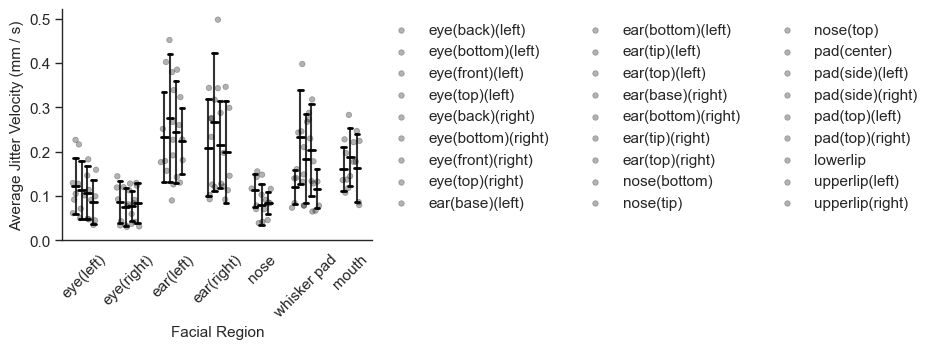

In [9]:
fig, ax = plt.subplots(figsize=(4, 3))

# sort the data by region and compute manual dodge factors
sub_df = jitter_df.query("mouse.str.startswith('B') & coordinate == 'vector'")
sub_df = sort_by_region(sub_df, REGION_ORDER, "landmark")
hue_order = sub_df.drop_duplicates("landmark")["landmark"].values

dodges = compute_dodges(sub_df, x="region", hue="landmark", gap=0.1)
dodge_shift = so.Shift(x=dodges["dodge"])
dodges_agg = dodges.drop_duplicates("landmark")
dodge_shift_agg = so.Shift(x=dodges_agg["dodge"].values)

p = (so.Plot(sub_df, x="region", y="velocity_mean", color="landmark")
        # plot scatter of samples
        .add(so.Dot(pointsize=4, alpha=0.3), dodge_shift, so.Jitter())
        # plot mean bar
        .add(so.Dash(linewidth=2, width=0.15), so.Agg(), dodge_shift_agg)
        # plot stddev whiskers
        .add(so.Dash(linewidth=2, width=0.1),
             so.Agg(lambda x: x.mean() + x.std(ddof=1)),
             dodge_shift_agg)
        .add(so.Dash(linewidth=2, width=0.1),
             so.Agg(lambda x: x.mean() - x.std(ddof=1)),
             dodge_shift_agg)
        # connect mean to whiskers (stddev range)
        .add(so.Range(alpha=0.8), so.Est(errorbar="sd"), dodge_shift_agg)
        .theme({"axes.prop_cycle": plt.cycler(color=['black' for _ in hue_order])})
        # Line below sets a color per landmark
        # .theme({"axes.prop_cycle": plt.cycler(color=[LANDMARK_CMAP[l] for l in hue_order])})
        .on(ax).plot())

ax.set_xlabel("Facial Region")
ax.set_ylabel("Average Jitter Velocity (mm / s)")
ax.tick_params(axis="x", rotation=45, bottom=False)
ax.set_ylim(0, None)
# hack to customize legends with seaborn objects interface
legend = fig.legends.pop(0)
ax.legend(legend.legend_handles, [t.get_text() for t in legend.texts],
          ncols=3, frameon=False, bbox_to_anchor=(1.0, 1.0))
sns.despine(fig)
# save_figure(OUTPUT_DIR, "b-long-anes-keypoint-jitter-summary", fig)
fname =  "b-long-anes-keypoint-jitter-summary"
fig.savefig(os.sep.join([OUTPUT_DIR, f"{fname}.svg"]), bbox_inches="tight")

### stats

In [10]:
stats_df = jitter_df.query("coordinate == 'vector'")[["mouse", "landmark", "velocity_mean"]].pivot(
    columns="landmark", index="mouse"
)
# stats_df.to_clipboard(excel=True)
# jitter_df.to_pickle(COORD_DATA_CACHE)
stats_df # Note these measurements were reported in the manuscript per region and further averaged across mice

velocity_mean                                     \
landmark ear(base)(left) ear(base)(right) ear(bottom)(left)   
mouse                                                         
B15             0.179080         0.233366          0.267036   
B20             0.251265         0.101985          0.089990   
B26             0.156896         0.092676          0.191686   
B6              0.176313         0.275083          0.451959   
B8              0.402257         0.343859          0.379460   

                                                                           \
landmark ear(bottom)(right) ear(tip)(left) ear(tip)(right) ear(top)(left)   
mouse                                                                       
B15                0.275281       0.226825        0.197448       0.180738   
B20                0.125790       0.125999        0.127631       0.130186   
B26                0.120199       0.142791        0.121430       0.227569   
B6                 0.317262       0.385027        0.343170       0.260076   
B8                 0.497847       0.338988        0.287390       0.323021   

                                                           ...               \
landmark ear(top)(right) eye(back)(left) eye(back)(right)  ... nose(bottom)   
mouse                                                      ...                
B15             0.145529        0.105022         0.092341  ...     0.116696   
B20             0.092093        0.091834         0.043104  ...     0.078628   
B26             0.113037        0.061182         0.033624  ...     0.070405   
B6              0.346335        0.129214         0.119072  ...     0.155440   
B8              0.299015        0.226597         0.144498  ...     0.142894   

                                                                           \
landmark nose(tip) nose(top) pad(center) pad(side)(left) pad(side)(right)   
mouse                                                                       
B15       0.069900  0.085296    0.139759        0.243196         0.267362   
B20       0.041742  0.091504    0.084120        0.148639         0.078397   
B26       0.038968  0.045463    0.073685        0.131968         0.078568   
B6        0.102764  0.083671    0.140855        0.245790         0.210178   
B8        0.148099  0.116023    0.160436        0.397821         0.287702   

                                                                        
landmark pad(top)(left) pad(top)(right) upperlip(left) upperlip(right)  
mouse                                                                   
B15            0.229691        0.128397       0.176939        0.224346  
B20            0.133481        0.066861       0.118000        0.079470  
B26            0.064973        0.078277       0.144948        0.086089  
B6             0.273082        0.132529       0.221457        0.177568  
B8             0.317818        0.178224       0.282953        0.246684  

[5 rows x 27 columns]

## Figure c

(code from 2024-04-25-long-anes-2D-jitter.ipynb)

Reduction of keypoint-specific jitter for an example keypoint from the left eye region in left camera view for an example mouse in 2D keypoints (prior to triangulation, dashed line) compared to 3D keypoints reprojected onto the 2D camera view plane (after triangulation, solid line).

### load 2D data

In [11]:
COORDINATE_PATHS = {}
key_cols = ('mouse', 'source', 'condition', 'dataset', 'view')
datasets = ('pose-2d', 'pose-2d-proj')
for d in datasets:
    for p in Path(ANIPOSE_BASE).glob(f'*/{d}/*.h5'):
        mouse = p.name.split('_')[1]
        view = p.name.split('_')[5]
        source = 'rig2'
        condition = 'awake' if 'awake' in p.name else 'anes'
        if condition == "awake":
            continue
        COORDINATE_PATHS[(mouse, source, condition, d, view)] = p
data_keys = list(COORDINATE_PATHS.keys())
# data_keys

In [12]:
def read_2d_data(p, landmarks):
    dlc_df = pd.read_hdf(p)
    data_dict = {}
    root = dlc_df.keys()[0][0]
    for l in landmarks:
        x_coord = dlc_df[root][l]['x'].values
        y_coord = dlc_df[root][l]['y'].values
        data_dict[l] = np.stack([x_coord, y_coord], 1)

    return data_dict

view_dict = {'R': ['nose(bottom)', 'nose(tip)', 'nose(top)', 
                   'pad(top)(right)', 'pad(side)(right)', 'pad(center)', 
                   'lowerlip', 'upperlip(right)', 
                   'eye(front)(right)', 'eye(top)(right)', 'eye(back)(right)', 'eye(bottom)(right)', 
                   'ear(base)(right)', 'ear(top)(right)', 'ear(tip)(right)', 'ear(bottom)(right)'],
             'L': ['nose(bottom)', 'nose(tip)', 'nose(top)', 
                   'pad(top)(left)', 'pad(side)(left)', 'pad(center)', 
                   'lowerlip', 'upperlip(left)', 
                   'eye(front)(left)', 'eye(top)(left)', 'eye(back)(left)', 'eye(bottom)(left)', 
                   'ear(base)(left)', 'ear(top)(left)', 'ear(tip)(left)', 'ear(bottom)(left)'],
             'TR': ['nose(tip)', 'nose(top)', 
                   'pad(top)(right)',
                   'eye(front)(right)', 'eye(top)(right)', 'eye(back)(right)', 'eye(bottom)(right)', 
                   'ear(base)(right)', 'ear(top)(right)', 'ear(tip)(right)', 'ear(bottom)(right)'],
             'TL': ['nose(tip)', 'nose(top)', 
                   'pad(top)(left)', 
                   'eye(front)(left)', 'eye(top)(left)', 'eye(back)(left)', 'eye(bottom)(left)', 
                   'ear(base)(left)', 'ear(top)(left)', 'ear(tip)(left)', 'ear(bottom)(left)'],
             'TC': ['nose(tip)', 'nose(top)', 
                   'eye(front)(left)', 'eye(top)(left)', 'eye(back)(left)', 'eye(bottom)(left)', 
                   'eye(front)(right)', 'eye(top)(right)', 'eye(back)(right)', 'eye(bottom)(right)'],
             'BC': ['nose(bottom)', 'nose(tip)', 'nose(top)',  
                   'pad(top)(left)', 'pad(side)(left)', 'pad(center)', 
                   'pad(top)(right)', 'pad(side)(right)', 'pad(center)', 
                   'lowerlip', 'upperlip(left)', 'upperlip(right)']
                   }

coord_data = {k: read_2d_data(p, view_dict[k[4]]) for k,p in COORDINATE_PATHS.items()}

In [13]:
def build_jitter_df(coord_data, periods):
    jitter_df = []
    for mouse, period in periods.items():
        start = round(period[0] * 60 * 100)
        end = round(period[1] * 60 * 100)
        for d in datasets:
            if d == 'pose-2d':
                ds_name = 'Pre-triangulation 2D'
            elif d == 'pose-2d-proj':
                ds_name = 'Post-triangulation 2D'

            for v in view_dict.keys():
                positions = coord_data[(mouse, "rig2", "anes", d, v)]
                for name, timeseries in positions.items():
                    if "eye" in name:
                        if "left" in name:
                            group = "eye(left)"
                        else:
                            group = "eye(right)"
                    elif "ear" in name:
                        if "left" in name:
                            group = "ear(left)"
                        else:
                            group = "ear(right)"
                    elif "lip" in name:
                        group = "mouth"
                    elif "nose" in name:
                        group = "nose"
                    elif "pad" in name:
                        group = "whisker pad"
                    elif "ref" in name:
                        continue
                    else:
                        raise ValueError(f"Cannot map {name} to landmark group.")
                    for i, coord in enumerate(("x", "y")):
                        xs = timeseries[start:end, i]
                        vs = np.abs(np.diff(xs)) * 100
                        dev = (xs - np.mean(xs))
                        jitter_df.append([mouse, ds_name, v, group, name, coord, xs, vs, dev,
                                        np.std(xs), np.min(dev), np.max(dev),
                                        np.std(vs), np.min(vs), np.max(vs), np.mean(vs)])
                    # 3d deviations --> 2D ?
                    xs = timeseries[start:end]
                    vs = np.linalg.norm(np.diff(xs, axis=0), axis=-1) * 100
                    dev = np.linalg.norm(xs - np.mean(xs, axis=0), axis=-1)

                    jitter_df.append([mouse, ds_name, v, group, name, "vector", xs, vs, dev,
                                    np.std(dev), np.min(dev), np.max(dev),
                                    np.std(vs), np.min(vs), np.max(vs), np.mean(vs)])

    jitter_df = pd.DataFrame(jitter_df, columns=["mouse",
                                                 "dataset",
                                                 "view",
                                                 "region",
                                                 "landmark",
                                                 "coordinate",
                                                 "positions",
                                                 "velocities",
                                                 "deviations",
                                                 "position_stddev",
                                                 "min_deviation",
                                                 "max_deviation",
                                                 "velocity_stddev",
                                                 "min_velocity",
                                                 "max_velocity",
                                                 "mean_velocity"])

    return jitter_df

jitter_df = build_jitter_df(coord_data, STILL_PERIODS)
jitter_df

,mouse,dataset,view,region,landmark,coordinate,positions,velocities,deviations,position_stddev,min_deviation,max_deviation,velocity_stddev,min_velocity,max_velocity,mean_velocity
0,B6,Pre-triangulation 2D,R,nose,nose(bottom),x,"[529.0158896446228, 529.0160136222839, 529.019...","[0.01239776611328125, 0.3748893737792969, 0.07...","[-0.1265613965014154, -0.1264374188402826, -0....",0.246464,-2.194242,0.955868,16.505774,0.000000,242.419052,8.903870
1,B6,Pre-triangulation 2D,R,nose,nose(bottom),y,"[399.55461072921753, 399.5613212585449, 399.55...","[0.6710529327392578, 0.8528709411621094, 0.262...","[-0.09728439710517023, -0.09057386777777765, -...",0.252181,-1.206047,0.805329,10.654130,0.000000,115.115213,7.706130
2,B6,Pre-triangulation 2D,R,nose,nose(bottom),vector,"[[529.0158896446228, 399.55461072921753], [529...","[0.671167447916359, 0.9316280829018496, 0.2718...","[0.15963095252646003, 0.15553149651186218, 0.1...",0.197992,0.000919,2.213308,18.736204,0.000000,245.617413,13.174562
3,B6,Pre-triangulation 2D,R,nose,nose(tip),x,"[560.4838697910309, 560.4677095413208, 560.473...","[1.6160249710083008, 0.5662679672241211, 0.104...","[0.06246425826270752, 0.04630400855262451, 0.0...",0.126153,-0.572302,0.478271,4.369878,0.000000,48.716426,3.784751
4,B6,Pre-triangulation 2D,R,nose,nose(tip),y,"[377.1570906639099, 377.15588569641113, 377.15...","[0.12049674987792969, 0.21696090698242188, 0.0...","[-0.1428526861173509, -0.1440576536161302, -0....",0.156966,-0.686704,0.967835,6.919849,0.000000,85.262394,5.184270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,B26,Post-triangulation 2D,BC,mouth,upperlip(left),y,"[349.1247100871942, 349.1209356986998, 349.118...","[0.37743884944347883, 0.20098771451557695, 0.0...","[-0.22754164614758565, -0.23131603464202044, -...",0.111741,-0.435018,0.375612,0.572048,0.000092,4.163789,0.746608
2246,B26,Post-triangulation 2D,BC,mouth,upperlip(left),vector,"[[366.08724703229734, 349.1247100871942], [366...","[0.40125091661296564, 0.48530870600935194, 0.6...","[0.22754911329072366, 0.23131653625802684, 0.2...",0.080490,0.000880,0.519095,0.706741,0.007354,4.655062,1.311173
2247,B26,Post-triangulation 2D,BC,mouth,upperlip(right),x,"[281.22110560686036, 281.2421121886636, 281.26...","[2.100658180324899, 2.02099171827399, 1.891833...","[-0.003376254384988897, 0.017630327418260094, ...",0.145783,-0.542846,0.499350,0.729644,0.000023,5.300085,0.942261
2248,B26,Post-triangulation 2D,BC,mouth,upperlip(right),y,"[351.0494625029654, 351.05480379196143, 351.05...","[0.5341288996021376, 0.34835881358503684, 0.17...","[0.23760514264461108, 0.24294643164063245, 0.2...",0.133653,-0.594435,0.437461,0.534052,0.000099,6.070977,0.656977


### figure

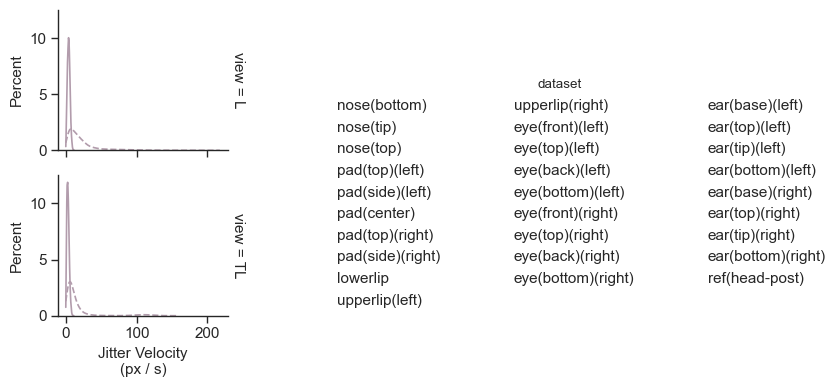

In [14]:
# landmark = "eye(front)(left)"
landmark = "ear(top)(left)"
def plot_histogram(velocities, color, label):
    sns.histplot(x=np.concatenate(velocities.values, axis=0),
                 color=LANDMARK_CMAP[landmark],
                 line_kws={"linestyle": "dashed" if label.startswith("Pre")
                                                 else "solid"},
                 label=label,
                 kde=True,
                 stat="percent",
                 binwidth=0.5, #post-triangulation: 0.8
                 # hack to hide bars but keep percent y-axis
                 fill=False,
                 linewidth=0)
ncols = 2 #len(jitter_df["region"].unique())
total_width = 6 # inches
facet_width = total_width / ncols
total_height = 2
aspect = facet_width / total_height

g = sns.FacetGrid(jitter_df.query("mouse == 'B6' & "
                                  "coordinate =='vector' & "
                                  "landmark == @landmark"),
                  row='view', hue="dataset",
                  # col_order=REGION_ORDER,
                  aspect=aspect,
                  height=total_height,
                  margin_titles=True)
# g.map_dataframe(plot_histogram, "velocities")
g.map(plot_histogram, "velocities")
g.add_legend(label_order=list(LANDMARK_CMAP.keys()), ncols=3)
# g.figure.suptitle("Coordinate-wise Deviation from Mean Landmark Position")
g.set_xlabels("Jitter Velocity\n(px / s)")
g.tight_layout(w_pad=0.5)
for i, ax in enumerate(g.axes[:, 1:].flat):
    sns.despine(ax=ax, left=True)
    ax.tick_params(axis="y", left=False)

fname = "c-long-anes-2d-vs-2dproj-eye-front-left"
g.figure.savefig(os.sep.join([OUTPUT_DIR, f"{fname}.svg"]), bbox_inches="tight")

## Figure d

Changes in jitter for all keypoints from one example view (left camera) across mice (n= 5) between pre-
triangulation (2D keypoints, shaded region) and post-triangulation (reprojected 2D keypoints). See Supplementary
Figure 3 for all views and summary statistics.

### sort data

In [15]:
def sort_by_region(df, region_order, *columns):
    df.loc[:, "region_rank"] = df["region"].transform(lambda x: region_order.index(x))
    df = df.sort_values(by=["region_rank", *columns])
    df = df.drop(columns=["region_rank"])

    return df

sort_by_region(jitter_df, REGION_ORDER, "landmark")

,mouse,dataset,view,region,landmark,coordinate,positions,velocities,deviations,position_stddev,min_deviation,max_deviation,velocity_stddev,min_velocity,max_velocity,mean_velocity
78,B6,Pre-triangulation 2D,L,eye(left),eye(back)(left),x,"[221.33339321613312, 221.3367280960083, 221.33...","[0.33348798751831055, 0.0779271125793457, 0.31...","[-0.09428598425230916, -0.09095110437712606, -...",0.155794,-0.662846,0.580314,4.960801,0.000000,64.056468,4.923276
79,B6,Pre-triangulation 2D,L,eye(left),eye(back)(left),y,"[276.192825704813, 276.19670459628105, 276.200...","[0.38788914680480957, 0.3346577286720276, 0.04...","[-0.13710584168251216, -0.13322695021446407, -...",0.221691,-0.847107,1.025902,7.541196,0.000000,83.348891,6.780276
80,B6,Pre-triangulation 2D,L,eye(left),eye(back)(left),vector,"[[221.33339321613312, 276.192825704813], [221....","[0.5115390777134978, 0.343610870367738, 0.3142...","[0.16639669062182932, 0.16131188316694517, 0.1...",0.133063,0.000324,1.040288,8.129311,0.000000,86.584690,9.252258
144,B6,Pre-triangulation 2D,TL,eye(left),eye(back)(left),x,"[301.9204851388931, 301.9216593503952, 301.926...","[0.11742115020751953, 0.49250125885009766, 0.0...","[-0.00619557562532691, -0.005021364123251715, ...",0.200896,-0.849277,0.883184,6.044499,0.000000,75.929797,5.327791
145,B6,Pre-triangulation 2D,TL,eye(left),eye(back)(left),y,"[261.87801027297974, 261.88577151298523, 261.8...","[0.7761240005493164, 0.02460479736328125, 0.18...","[-0.18055329693328304, -0.17279205692778987, -...",0.250495,-1.017264,0.988898,7.545326,0.000000,97.327614,7.392681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047,B26,Post-triangulation 2D,R,mouth,upperlip(right),y,"[398.28895249334226, 398.2896807667329, 398.28...","[0.07282733906208705, 0.07149631272795887, 0.1...","[0.182158472540209, 0.18288674593082987, 0.182...",0.125046,-0.478362,0.404020,0.428195,0.000026,4.321621,0.510359
2048,B26,Post-triangulation 2D,R,mouth,upperlip(right),vector,"[[451.33484661559254, 398.28895249334226], [45...","[0.34260089795703214, 0.33129929988648793, 0.3...","[0.18780497250536335, 0.1893509583438495, 0.18...",0.144663,0.001975,0.948681,0.667856,0.004625,7.475572,0.966508
2247,B26,Post-triangulation 2D,BC,mouth,upperlip(right),x,"[281.22110560686036, 281.2421121886636, 281.26...","[2.100658180324899, 2.02099171827399, 1.891833...","[-0.003376254384988897, 0.017630327418260094, ...",0.145783,-0.542846,0.499350,0.729644,0.000023,5.300085,0.942261
2248,B26,Post-triangulation 2D,BC,mouth,upperlip(right),y,"[351.0494625029654, 351.05480379196143, 351.05...","[0.5341288996021376, 0.34835881358503684, 0.17...","[0.23760514264461108, 0.24294643164063245, 0.2...",0.133653,-0.594435,0.437461,0.534052,0.000099,6.070977,0.656977


In [16]:
def compute_dodges(df, x, hue, gap = 0.1):
    subgroups = df.groupby(x)[hue].unique().values
    dodges = {}
    for subgroup in subgroups:
        count = len(subgroup)
        if count == 1:
            shifts = [0]
        elif count == 2:
            shifts = [-1, 1]
        else:
            shifts = [*np.linspace(start=-count / 2, stop=count / 2, num=count)]
        for name, shift in zip(subgroup, shifts):
            dodges[name] = shift * gap

    dodge_df = df[[x, hue]].copy()
    dodge_df["dodge"] = df.groupby(x)[hue].transform(lambda x: [dodges[xi] for xi in x])

    return dodge_df

compute_dodges(jitter_df.query("coordinate == 'vector' & view == 'TR'"),
               "region", "landmark")

,region,landmark,dodge
98,nose,nose(tip),-0.100000
101,nose,nose(top),0.100000
104,whisker pad,pad(top)(right),0.000000
107,eye(right),eye(front)(right),-0.200000
110,eye(right),eye(top)(right),-0.066667
...,...,...,...
2141,eye(right),eye(bottom)(right),0.200000
2144,ear(right),ear(base)(right),-0.200000
2147,ear(right),ear(top)(right),-0.066667
2150,ear(right),ear(tip)(right),0.066667


### figure

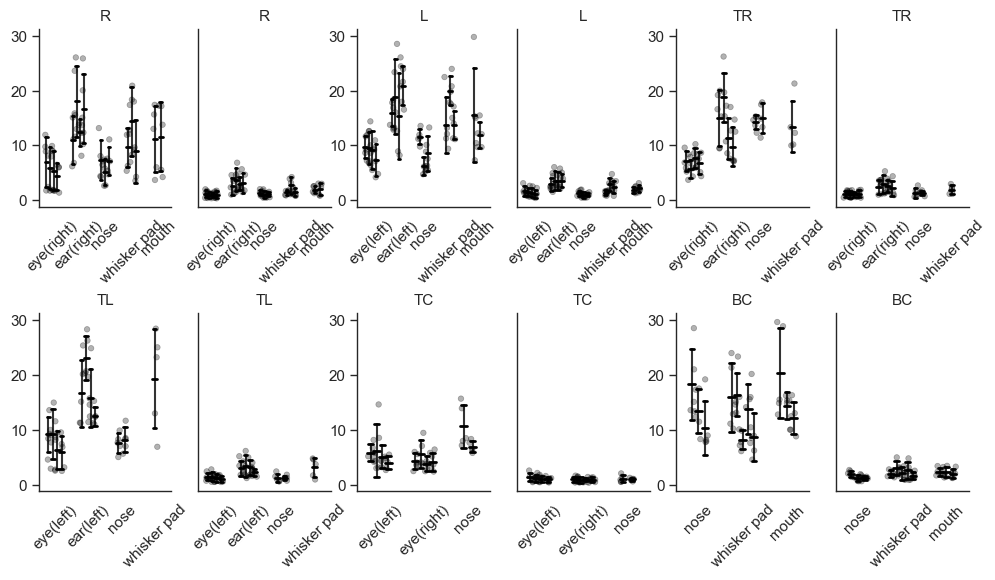

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=6,
                       sharex=False, sharey=True,
                       figsize=(12, 6))

plot_w_color = False

for j, d in enumerate(datasets):
    if d == 'pose-2d':
        dataset_name = 'Pre-triangulation 2D'
    elif d == 'pose-2d-proj':
        dataset_name = 'Post-triangulation 2D'
    for i, v in enumerate(view_dict.keys()):
        row = i // 3
        col = (i % 3)*2 + j
        # sort the data by region and compute manual dodge factors
        sub_df = jitter_df.query("coordinate == 'vector' & dataset==@dataset_name & view == @v")
        sub_df = sort_by_region(sub_df, REGION_ORDER, "landmark")
        hue_order = sub_df.drop_duplicates("landmark")["landmark"].values

        dodges = compute_dodges(sub_df, x="region", hue="landmark", gap=0.1)
        dodge_shift = so.Shift(x=dodges["dodge"])
        dodges_agg = dodges.drop_duplicates("landmark")
        dodge_shift_agg = so.Shift(x=dodges_agg["dodge"].values)

        if plot_w_color:
            cmap = plt.cycler(color=[LANDMARK_CMAP[l] for l in hue_order])
        else:
            cmap = plt.cycler(color=["black" for _ in hue_order])
        p = (so.Plot(sub_df, x="region", y="mean_velocity", color="landmark")
            # plot scatter of samples
            .add(so.Dot(alpha=0.3, pointsize=4), dodge_shift, so.Jitter())
            # plot mean bar
            .add(so.Dash(linewidth=2, width=0.15), so.Agg(), dodge_shift_agg)
            # plot stddev whiskers
            .add(so.Dash(linewidth=2, width=0.1),
                so.Agg(lambda x: x.mean() + x.std(ddof=1)),
                dodge_shift_agg)
            .add(so.Dash(linewidth=2, width=0.1),
                so.Agg(lambda x: x.mean() - x.std(ddof=1)),
                dodge_shift_agg)
            # connect mean to whiskers (stddev range)
            .add(so.Range(alpha=0.8), so.Est(errorbar="sd"), dodge_shift_agg)
            .theme({"axes.prop_cycle": cmap})
            .label(x = None, y = None)
            .on(ax[row, col]).plot())
        ax[row, col].set_title(f"{v}")
        if j == 1:
            ax[row, col].tick_params(axis='y', left=False, labelleft=False)
        # if i == 3 & j == 0:
        #     ax[i, j].set_ylabel("Standard Deviation (px / s)")
        ax[row, col].tick_params(axis="x", rotation=45, bottom=False)
# hack to customize legends with seaborn objects interface
legend_dict = {}
while len(fig.legends) > 0:
    legend = fig.legends.pop(0)
    for label, handle in zip(legend.texts, legend.legend_handles):
        label_text = label.get_text()
        if label_text not in legend_dict:
            legend_dict[label_text] = handle
# ax[0, 1].legend(list(legend_dict.values()), list(legend_dict.keys()),
#              ncols=3, frameon=False, bbox_to_anchor=(3.5, 1.0))
sns.despine(fig)
# fig.suptitle("Standard Deviation (px / s) per view", y=0.91)
fig.subplots_adjust(hspace=0.6)

fname = "d-long-anes-keypoint-jitter-summary-2Dpos-vs-2Dreproj"
fig.savefig(os.sep.join([OUTPUT_DIR, f"{fname}.svg"]), bbox_inches="tight")

## Figure e

Summary of keypoint-specific jitter across mice and all six camera views. See Supplementary Figure 3 for
summary statistics.

### figure

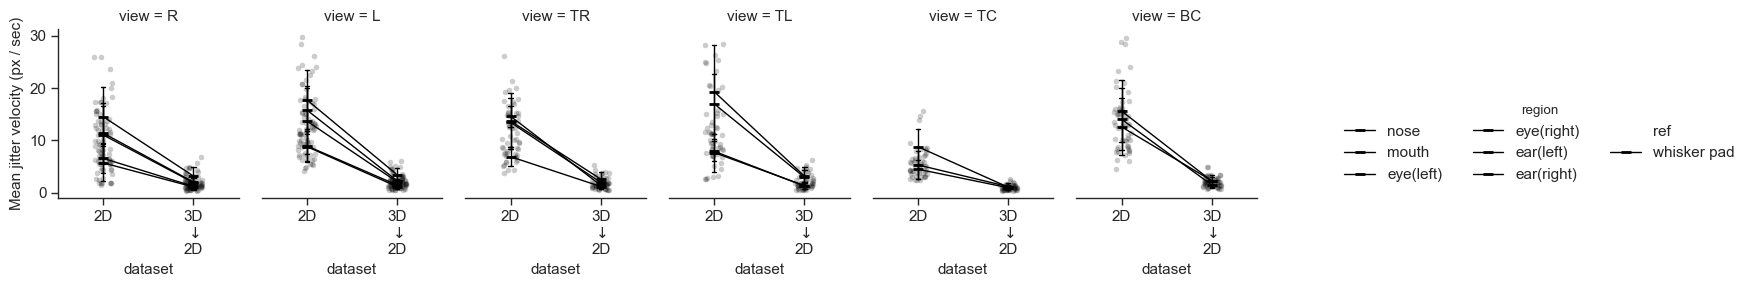

In [18]:
plot_w_color = False

centers_cmap = landmark_cmap(flat=False)[1]
centers_cmap = {k: np.mean(v, axis=0) for k, v in centers_cmap.items()}
centers_cmap["whisker pad"] = (centers_cmap["whiskers(left)"] +
                        centers_cmap["whiskers(right)"]) / 2
del centers_cmap["whiskers(left)"]
del centers_cmap["whiskers(right)"]

if not plot_w_color:
    centers_cmap = {k: "black" for k in centers_cmap.keys()}

def plot_2d_vs_2dproj(dataset, region, landmark, velocity, color, label):
    xs = dataset.values
    ys = velocity.values
    _region = region.unique()[0]
    all_ys = []
    for d in dataset.unique():
        _ys = np.concatenate([ys[xs == d][landmark[xs == d] == l]
                              for l in landmark.unique()], axis=0)
        all_ys.append(_ys)
    xs = np.repeat(dataset.unique(), [len(y) for y in all_ys])
    ys = np.concatenate(all_ys, axis=0)
    sns.stripplot(x=xs, y=ys,
                  color=centers_cmap[_region],
                  dodge=True,
                  alpha=0.2,
                  size=4)
    xs = dataset.values
    ys = velocity.values
    sns.pointplot(x=xs, y=ys,
                  errorbar=(lambda x: (x.mean() - x.std(ddof=1),
                                       x.mean() + x.std(ddof=1))),
                  capsize=0.05,
                  linewidth=1,
                  marker="_", markersize=7.5, markeredgewidth=2,
                  color=centers_cmap[_region],
                  label=label)

g = sns.FacetGrid(jitter_df.query("coordinate =='vector'"),
                  col="view", hue="region",
                  aspect=0.75,
                  margin_titles=True)
g.map(plot_2d_vs_2dproj, "dataset", "region", "landmark", "mean_velocity")
g.add_legend(label_order=list(centers_cmap.keys()), ncols=3)
# # g.figure.suptitle("Coordinate-wise Deviadtion from Mean Landmark Position")
g.set_xticklabels(["2D", "3D\n$\\downarrow$\n2D"])
g.set_ylabels("Mean jitter velocity (px / sec)")
g.tight_layout(h_pad=0.01)
for ax in g.axes.flat[1:]:
    sns.despine(ax=ax, left=True)
    ax.tick_params(axis="y", left=False)

fname = "e-long-anes-2d-vs-2dproj-summary"
g.figure.savefig(os.sep.join([OUTPUT_DIR, f"{fname}.svg"]), bbox_inches="tight")

### stats

In [19]:
for view in jitter_df["view"].unique():
    for region in jitter_df["region"].unique():
        pre = jitter_df.query(
            "coordinate == 'vector' & "
            "view == @view & "
            "region == @region & "
            "dataset == 'Pre-triangulation 2D'"
        )["mean_velocity"].values
        post = jitter_df.query(
            "coordinate == 'vector' & "
            "view == @view & "
            "region == @region & "
            "dataset == 'Post-triangulation 2D'"
        )["mean_velocity"].values
        if pre.shape[0] == 0 or post.shape[0] == 0:
            continue
        stat, pval = wilcoxon(pre, post, alternative="greater")
        print(view, region)
        print("p =", pval)
        print()

R nose
p = 3.0517578125e-05

R whisker pad
p = 3.0517578125e-05

R mouth
p = 0.0009765625

R eye(right)
p = 9.5367431640625e-07

R ear(right)
p = 9.5367431640625e-07

L nose
p = 3.0517578125e-05

L whisker pad
p = 3.0517578125e-05

L mouth
p = 0.0009765625

L eye(left)
p = 9.5367431640625e-07

L ear(left)
p = 9.5367431640625e-07

TR nose
p = 0.0009765625

TR whisker pad
p = 0.03125

TR eye(right)
p = 9.5367431640625e-07

TR ear(right)
p = 9.5367431640625e-07

TL nose
p = 0.0009765625

TL whisker pad
p = 0.03125

TL eye(left)
p = 9.5367431640625e-07

TL ear(left)
p = 9.5367431640625e-07

TC nose
p = 0.0009765625

TC eye(right)
p = 9.5367431640625e-07

TC eye(left)
p = 9.5367431640625e-07

BC nose
p = 3.0517578125e-05

BC whisker pad
p = 2.9802322387695312e-08

BC mouth
p = 3.0517578125e-05



## Figure f

### load Facemap data

(from 2024-11-1-Cheese3D-vs-Facemap.ipynb)

Jitter comparison between Cheese3D (black) and Facemap (green) across facial regions. Each point repre-
sents the mean jitter velocity across all keypoints for the facial regions as well as camera views for a single mouse.
Cheese3D’s 3D keypoints are reprojected onto 2D views to compare with Facemap. Note Facemap’s output does
not include the mouse’s ears. Measurements for lateralized facial features (eyes, ears) contain both left and right
sides and thus have twice the amount of data points compared to midline features (nose, whisker pad). See Supplementary Figure 5 for the same data broken down by camera view.

In [20]:
FACEMAP_BASE = './facemap-projects/'
JITTER_DIR = "20240919_long-anes-clips_rig2"


STILL_PERIODS = { #Set to None because I am using the clips (time windows below only)
    "B6": (None,None), #(38.50, 44.05),
    "B8": (None,None), #(34.30, 39.55),
    "B15": (None,None), #(27.20, 34.15),
    "B20": (None,None), #(34.55, 41.00),
    "B26": (None,None), #(58.20, 63.28),
    # "B33": (44.30, 50.05)
}

MICE_A = ["B6", "B8", "B15", "B20", "B26"]

#Long-anes clips from year 2023 dataset: Load 2D and 3D data from Facemap and Cheese3D (pre, post-triangulation 2D & 3D)

COORDINATE_PATHS_FM = {}
COORDINATE_PATHS_C3D_PRE = {}
COORDINATE_PATHS_C3D_POST = {}
COORDINATE_PATHS_C3D_3D = {}
key_cols = ('mouse', 'source', 'condition', 'dataset', 'view')
models = ['./anipose-projects/', FACEMAP_BASE]
for m in models:
    source = 'rig2'
    if m == FACEMAP_BASE:
        for p in Path(m).glob(f'{JITTER_DIR}/*/*.h5'):
            mouse = p.name.split('_')[2]
            view = p.name.split('_')[6]
            COORDINATE_PATHS_FM[(mouse, source, 'anes', 'facemap', view)] = p
    else: 
        for mo in MICE_A:
            folder = f'*{mo}*/videos-2d-proj' #Post-triangulation 2D
            # print(folder1)
            for p1 in Path(m).glob(f'{JITTER_DIR}/{folder}/*.h5'):
                mouse = p1.name.split('_')[1]
                view = p1.name.split('_')[5]
                COORDINATE_PATHS_C3D_POST[(mouse, source, 'anes', 'c3d-post-tri-2D', view)] = p1



In [21]:
# CHEESE3D (in 2D)
def read_2d_data(p, landmarks): #Modified from the read_2d_data function in fepipeline.features.landmarks
    dlc_df = pd.read_hdf(p)
    data_dict = {}
    root = dlc_df.keys()[0][0]
    for l in landmarks:
        try:
            dlc_df[root][l] #if the landmark name is for Facemap
        except KeyError:
            continue
        x_coord = dlc_df[root][l]['x'].values
        y_coord = dlc_df[root][l]['y'].values
        data_dict[l] = np.stack([x_coord, y_coord], 1)

    return data_dict

view_dict = {'R': ['nose(bottom)', 'nose(tip)', 'nose(top)', # nosebridge - facemap specific 
                   'pad(top)(right)', 'pad(side)(right)', 'pad(center)', 
                   'whisker(I)', 'whisker(II)', 'whisker(III)', # - facemap specific
                   'lowerlip', 'upperlip(right)', 'mouth', #mouth - facemap specific
                   'eye(front)(right)', 'eye(top)(right)', 'eye(back)(right)', 'eye(bottom)(right)', 
                   'eye(front)', 'eye(top)', 'eye(back)', 'eye(bottom)', # - facemap specific
                   'ear(base)(right)', 'ear(top)(right)', 'ear(tip)(right)', 'ear(bottom)(right)'],
             'L': ['nose(bottom)', 'nose(tip)', 'nose(top)', # nosebridge - facemap specific
                   'pad(top)(left)', 'pad(side)(left)', 'pad(center)', 
                   'lowerlip', 'upperlip(left)', 'mouth', #mouth - facemap specific
                   'eye(front)(left)', 'eye(top)(left)', 'eye(back)(left)', 'eye(bottom)(left)', 
                   'eye(front)', 'eye(top)', 'eye(back)', 'eye(bottom)', # - facemap specific
                   'ear(base)(left)', 'ear(top)(left)', 'ear(tip)(left)', 'ear(bottom)(left)'],
             'TR': ['nose(tip)', 'nose(top)', 'nose(bottom)', # nose(bottom), nosebridge - facemap specific 
                   'pad(top)(right)',
                   'mouth', 'lowerlip', # - facemap specific
                   'eye(front)(right)', 'eye(top)(right)', 'eye(back)(right)', 'eye(bottom)(right)', 
                   'eye(front)', 'eye(top)', 'eye(back)', 'eye(bottom)', # - facemap specific
                   'ear(base)(right)', 'ear(top)(right)', 'ear(tip)(right)', 'ear(bottom)(right)'],
             'TL': ['nose(tip)', 'nose(top)', 'nose(bottom)', # nose(bottom), nosebridge - facemap specific
                   'pad(top)(left)', 
                   'mouth', 'lowerlip', # - facemap specific
                   'eye(front)(left)', 'eye(top)(left)', 'eye(back)(left)', 'eye(bottom)(left)', 
                   'eye(front)', 'eye(top)', 'eye(back)', 'eye(bottom)', # - facemap specific
                   'ear(base)(left)', 'ear(top)(left)', 'ear(tip)(left)', 'ear(bottom)(left)'],
             'TC': ['nose(tip)', 'nose(top)',  # nosebridge - facemap specific 
                    'eye(front)', 'eye(top)', 'eye(back)', 'eye(bottom)', # - facemap specific (this is left eye)
                   'eye(front)(left)', 'eye(top)(left)', 'eye(back)(left)', 'eye(bottom)(left)', 
                   'eye(front)(right)', 'eye(top)(right)', 'eye(back)(right)', 'eye(bottom)(right)'],
             'BC': ['nose(bottom)', 'nose(tip)', 'nose(top)',  # nosebridge - facemap specific
                   'pad(top)(left)', 'pad(side)(left)', 'pad(center)', 
                   'pad(top)(right)', 'pad(side)(right)', 'pad(center)', 
                   'lowerlip', 'upperlip(left)', 'upperlip(right)', 'mouth']  #mouth - facemap specific
                   }


In [22]:
# Facemap function (adapted from their repo)
# Link: https://github.com/MouseLand/facemap/blob/main/facemap/utils.py
import h5py

def load_keypoints(bodyparts, h5_path, view):
    """Load keypoints using h5py

    Args:
        bodyparts (list): List of bodyparts in the same order as in FacemapDataset
        h5_path (hdf filepath): Path to hdf file containing keypoints
    Returns:
        pose_data (np.array): Array of size 3 x key points x frames
    """

    # pose_likelihood = []
    data_dict = {}
    pose_data = h5py.File(h5_path, "r")["Facemap"]

    for bodypart in bodyparts:  # Load bodyparts in the same order as in FacemapDataset
        try:
            pose_data[bodypart]
        except KeyError:
            continue # print(bodypart, ' does not exist in Facemap.')
        # else:      # print(bodypart, ' exists in Facemap.')
            
        # pose_likelihood.append(pose_data[bodypart]["likelihood"][:])
        x_coord = pose_data[bodypart]["x"][:]
        y_coord = pose_data[bodypart]["y"][:]
        bodypart_name = bodypart
        if 'eye' in bodypart:
            if view in ['L', 'TL', 'TC']:
                bodypart_name = bodypart + '(left)'
            else:
                bodypart_name = bodypart + '(right)'
        data_dict[bodypart_name] = np.stack([x_coord, y_coord], 1)

    # pose_likelihood = np.array([pose_likelihood])  # size: key points x frames

    return data_dict #pose_data

In [23]:
# CHEESE3D - Load 2D data
coord_data_c3d_post = {k: read_2d_data(p, view_dict[k[4]]) for k,p in COORDINATE_PATHS_C3D_POST.items()}

# FACEMAP (adapted from Facemap's utils) - Load 2D data
coord_data_fm = {k: load_keypoints(view_dict[k[4]], p, k[4]) for k,p in COORDINATE_PATHS_FM.items()}

In [24]:
# coord_data_fm['B8', 'rig2', 'anes', 'facemap', 'R'].keys()
fm_kp = []
c3d_kp = []
for v in view_dict.keys():
    # print(v, coord_data_fm['B8', 'rig2', 'anes', 'facemap', v].keys())
    for k in coord_data_fm['B8', 'rig2', 'anes', 'facemap', v].keys():
        fm_kp.append(k) if k not in fm_kp else _
    for k in coord_data_c3d_post['B8', 'rig2', 'anes', 'c3d-post-tri-2D', v].keys():
        c3d_kp.append(k) if k not in c3d_kp else _
print(f'Facemap has {len(fm_kp)} keypoints in total across views:\n{fm_kp}')
print(f'Cheese3D has {len(c3d_kp)} keypoints in total across views:\n{c3d_kp}')

Facemap has 16 keypoints in total across views:
['nose(bottom)', 'nose(tip)', 'nose(top)', 'whisker(I)', 'whisker(II)', 'whisker(III)', 'lowerlip', 'mouth', 'eye(front)(right)', 'eye(top)(right)', 'eye(back)(right)', 'eye(bottom)(right)', 'eye(front)(left)', 'eye(top)(left)', 'eye(back)(left)', 'eye(bottom)(left)']
Cheese3D has 27 keypoints in total across views:
['nose(bottom)', 'nose(tip)', 'nose(top)', 'pad(top)(right)', 'pad(side)(right)', 'pad(center)', 'lowerlip', 'upperlip(right)', 'eye(front)(right)', 'eye(top)(right)', 'eye(back)(right)', 'eye(bottom)(right)', 'ear(base)(right)', 'ear(top)(right)', 'ear(tip)(right)', 'ear(bottom)(right)', 'pad(top)(left)', 'pad(side)(left)', 'upperlip(left)', 'eye(front)(left)', 'eye(top)(left)', 'eye(back)(left)', 'eye(bottom)(left)', 'ear(base)(left)', 'ear(top)(left)', 'ear(tip)(left)', 'ear(bottom)(left)']


In [25]:
# Build jitter dataframes in 2D
def build_jitter_df_2d(data, periods, datasets):
    jitter_df = []
    for mouse, period in periods.items():
        if period[0]:
            start = round(period[0] * 60 * 100)
        else:
            start = None
        if period[1]:
            end = round(period[1] * 60 * 100)
        else:
            end = None
        for d in datasets:
            if d == 'c3d-post-tri-2D':
                ds_name = 'Post-triangulation 2D'
                coord_data = data[0]
            elif d == 'facemap':
                ds_name = 'Facemap'
                coord_data = data[1]

            for v in view_dict.keys():
                positions = coord_data[(mouse, "rig2", "anes", d, v)] 
                for name, timeseries in positions.items():
                    if "eye" in name:
                        if "left" in name: # or v in ["L", "TL", "TC"]:
                            group = "eye(left)"
                        else:
                            group = "eye(right)"
                    elif "ear" in name:
                        if "left" in name:
                            group = "ear(left)"
                        else:
                            group = "ear(right)"
                    elif "lip" in name or "mouth" in name:
                        group = "mouth"
                    elif "nose" in name:
                        group = "nose"
                    elif "pad" in name or "whisker" in name:
                        group = "whisker pad"
                    elif "ref" in name:
                        continue
                    else:
                        raise ValueError(f"Cannot map {name} to landmark group.")
                    for i, coord in enumerate(("x", "y")):
                        xs = timeseries[start:end, i]
                        vs = np.abs(np.diff(xs)) * 100
                        dev = (xs - np.mean(xs))
                        jitter_df.append([mouse, ds_name, v, group, name, coord, xs, vs, dev,
                                        np.std(xs), np.min(dev), np.max(dev),
                                        np.std(vs), np.min(vs), np.max(vs), np.mean(vs)])
                    # 3d deviations --> 2D ?
                    xs = timeseries[start:end]
                    vs = np.linalg.norm(np.diff(xs, axis=0), axis=-1) * 100
                    dev = np.linalg.norm(xs - np.mean(xs, axis=0), axis=-1)

                    jitter_df.append([mouse, ds_name, v, group, name, "vector", xs, vs, dev,
                                    np.std(dev), np.min(dev), np.max(dev),
                                    np.std(vs), np.min(vs), np.max(vs), np.mean(vs)])

    jitter_df = pd.DataFrame(jitter_df, columns=["mouse",
                                                 "dataset",
                                                 "view",
                                                 "region",
                                                 "landmark",
                                                 "coordinate",
                                                 "positions",
                                                 "velocities",
                                                 "deviations",
                                                 "position_stddev",
                                                 "min_deviation",
                                                 "max_deviation",
                                                 "velocity_stddev",
                                                 "min_velocity",
                                                 "max_velocity",
                                                 "mean_velocity"])

    return jitter_df

jitter_df_2d = build_jitter_df_2d([coord_data_c3d_post, coord_data_fm], 
                               STILL_PERIODS, ['c3d-post-tri-2D', 'facemap'])
jitter_df_2d

,mouse,dataset,view,region,landmark,coordinate,positions,velocities,deviations,position_stddev,min_deviation,max_deviation,velocity_stddev,min_velocity,max_velocity,mean_velocity
0,B6,Post-triangulation 2D,R,nose,nose(bottom),x,"[531.842336432014, 531.8489828490841, 531.8566...","[0.6646417070101052, 0.7662336472662901, 0.867...","[-0.15660534515450308, -0.14995892808440203, -...",0.130597,-0.502134,0.448056,0.754783,0.000012,5.137361,0.983482
1,B6,Post-triangulation 2D,R,nose,nose(bottom),y,"[399.88282013763285, 399.8798829880035, 399.87...","[0.2937149629360647, 0.560235036107315, 0.8259...","[-0.06282637269788438, -0.06576352232724503, -...",0.112963,-0.382886,0.534784,0.738092,0.000016,5.818833,0.960177
2,B6,Post-triangulation 2D,R,nose,nose(bottom),vector,"[[531.842336432014, 399.88282013763285], [531....","[0.7266478364034674, 0.9491982395080417, 1.197...","[0.16873762839593592, 0.16374529300239962, 0.1...",0.081523,0.000323,0.542916,0.842835,0.005131,6.467966,1.514359
3,B6,Post-triangulation 2D,R,nose,nose(tip),x,"[557.648949861077, 557.6511488817048, 557.6489...","[0.21990206278132973, 0.21746895274645794, 0.6...","[0.11099617191496236, 0.11319519254277566, 0.1...",0.099191,-0.420295,0.354322,0.681745,0.000024,5.081447,0.885067
4,B6,Post-triangulation 2D,R,nose,nose(tip),y,"[373.5192515149948, 373.52498566675257, 373.52...","[0.5734151757792461, 0.46872260253394415, 0.36...","[0.009315055701108577, 0.015049207458901037, 0...",0.087542,-0.405510,0.288499,0.621595,0.000079,4.575004,0.801844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,B26,Facemap,BC,mouth,lowerlip,y,"[231.99286, 231.99173, 231.95667, 231.96237, 2...","[0.11291504, 3.5064697, 0.5706787, 1.4770508, ...","[-0.03781128, -0.03894043, -0.07400513, -0.068...",0.090967,-0.219788,0.490707,8.248147,0.000000,59.858704,4.647597
1931,B26,Facemap,BC,mouth,lowerlip,vector,"[[165.22751, 231.99286], [165.29314, 231.99173...","[6.563776, 3.545314, 1.9485403, 4.6766357, 5.3...","[0.039041147, 0.04934227, 0.078738585, 0.08657...",0.078710,0.000458,0.693915,8.765542,0.011003,74.171127,7.141355
1932,B26,Facemap,BC,mouth,mouth,x,"[165.67812, 165.70854, 165.71516, 165.72922, 1...","[3.0426025, 0.66223145, 1.4053345, 0.46081543,...","[0.0032196045, 0.03364563, 0.040267944, 0.0543...",0.094554,-0.382111,0.356049,3.536295,0.000000,38.873291,4.426558
1933,B26,Facemap,BC,mouth,mouth,y,"[210.37814, 210.37451, 210.32777, 210.34433, 2...","[0.36315918, 4.673767, 1.6555786, 1.3397217, 6...","[-0.13793945, -0.14157104, -0.18830872, -0.171...",0.089865,-0.380981,0.378265,3.469371,0.000000,47.030640,4.241374


In [26]:
jitter_df_2d.query("mouse == 'B8' & dataset=='Facemap' & region == 'eye(left)' & coordinate == 'vector'")

,mouse,dataset,view,region,landmark,coordinate,positions,velocities,deviations,position_stddev,min_deviation,max_deviation,velocity_stddev,min_velocity,max_velocity,mean_velocity
677,B8,Facemap,L,eye(left),eye(front)(left),vector,"[[176.54742, 85.67872], [176.56845, 85.66043],...","[2.786677, 2.0655718, 1.6093105, 7.2781196, 6....","[0.06923082, 0.04384587, 0.059361357, 0.048881...",0.122854,0.000663,1.385748,6.483947,0.0,137.164932,5.170592
680,B8,Facemap,L,eye(left),eye(top)(left),vector,"[[187.46312, 45.73387], [187.4587, 45.73844], ...","[0.63612914, 3.0670655, 1.3196727, 6.4467444, ...","[0.09870625, 0.10243014, 0.09812866, 0.0849649...",0.585174,0.002882,2.877486,23.030903,0.0,342.325287,10.407983
683,B8,Facemap,L,eye(left),eye(back)(left),vector,"[[224.77861, 63.082016], [224.77768, 63.076828...","[0.5270824, 0.8263522, 0.80528975, 5.865686, 3...","[0.11178264, 0.11386277, 0.116608374, 0.117687...",0.251951,0.002705,1.565516,12.369894,0.0,175.319443,7.427975
686,B8,Facemap,L,eye(left),eye(bottom)(left),vector,"[[205.21582, 81.85481], [205.22449, 81.86582],...","[1.4011409, 1.5742464, 0.15286231, 6.1302056, ...","[0.19709872, 0.19454053, 0.18538427, 0.1867047...",0.162895,0.002028,1.183961,8.403279,0.0,118.993698,6.704159
731,B8,Facemap,TL,eye(left),eye(front)(left),vector,"[[214.3827, 63.969986], [214.38567, 63.96099],...","[0.9469627, 5.8120885, 1.5353619, 0.52034485, ...","[0.016650423, 0.020083947, 0.07016408, 0.08417...",0.126155,0.001277,1.052683,7.169920,0.0,107.783615,5.801987
734,B8,Facemap,TL,eye(left),eye(top)(left),vector,"[[239.07674, 20.266537], [239.06638, 20.270927...","[1.1252682, 2.2700002, 3.2712307, 0.33018625, ...","[0.13409956, 0.1268097, 0.13743988, 0.16405508...",0.146913,0.000616,0.775284,16.698755,0.0,97.105042,7.457083
737,B8,Facemap,TL,eye(left),eye(back)(left),vector,"[[278.19055, 40.614758], [278.19104, 40.62393]...","[0.9187331, 36.39158, 1.993469, 1.3286544, 1.4...","[0.29656035, 0.30261335, 0.13500059, 0.1318882...",0.139186,0.002376,1.116510,10.275356,0.0,116.122246,7.372247
740,B8,Facemap,TL,eye(left),eye(bottom)(left),vector,"[[259.79443, 73.715675], [259.77933, 73.726074...","[1.8339403, 5.7135983, 6.3721395, 0.56092656, ...","[0.12601319, 0.12521835, 0.11635697, 0.1785789...",0.202221,0.000834,1.262090,11.521840,0.0,141.232849,6.972984
749,B8,Facemap,TC,eye(left),eye(front)(left),vector,"[[87.880974, 61.935226], [87.891914, 61.935486...","[1.0943626, 1.3896612, 4.227201, 1.0149515, 3....","[0.11348455, 0.10910251, 0.11241319, 0.1028138...",0.248480,0.001260,6.926955,19.153791,0.0,647.432434,5.907633
752,B8,Facemap,TC,eye(left),eye(top)(left),vector,"[[251.12871, 25.254036], [251.13733, 25.265991...","[1.4739527, 3.2651718, 0.14129888, 0.7396509, ...","[0.08911381, 0.07638049, 0.05733023, 0.0565825...",0.157503,0.000641,1.177370,7.497254,0.0,137.321503,5.675020


In [27]:
avg_vel_stdv_list = []
datasets_2d = ['Post-triangulation 2D', 'Facemap']
for d in datasets_2d:
    dataset_name = d
    for v in view_dict.keys():
        for r in REGION_ORDER:
            for m in MICE_A:
                avg_vel_stdv = np.mean(jitter_df_2d.query("dataset == @dataset_name & "
                                                          "view == @v & "
                                                          "mouse == @m & "
                                                          "coordinate == 'vector' & "
                                                          "region == @r")["mean_velocity"])
                avg_vel_stdv_list.append([dataset_name, m, v, r, avg_vel_stdv])
avg_sub_df = pd.DataFrame(avg_vel_stdv_list, columns=["dataset", 
                                                        "mouse", 
                                                        "view", 
                                                        "region", 
                                                        "mean_region_velocity"])
avg_sub_df

,dataset,mouse,view,region,mean_region_velocity
0,Post-triangulation 2D,B6,R,eye(left),NaN
1,Post-triangulation 2D,B8,R,eye(left),NaN
2,Post-triangulation 2D,B15,R,eye(left),NaN
3,Post-triangulation 2D,B20,R,eye(left),NaN
4,Post-triangulation 2D,B26,R,eye(left),NaN
...,...,...,...,...,...
415,Facemap,B6,BC,mouth,12.826027
416,Facemap,B8,BC,mouth,8.396217
417,Facemap,B15,BC,mouth,8.147527
418,Facemap,B20,BC,mouth,15.563591


In [28]:
# Further average across views
avg_panview = []
common_v = {} 
for mouse in set(avg_sub_df['mouse']):
    for r in set(avg_sub_df['region']):
        # Exclude regions that are not in both Cheese3D and Facemap views (except the ears)
        # i.e., do not include views where keypoints are NaN 
        v_list_c3d = list(avg_sub_df.query("dataset == 'Post-triangulation 2D' & mouse == @m & region == @r & mean_region_velocity >= 0")['view'])
        v_list_fm = list(avg_sub_df.query("dataset == 'Facemap' & mouse == @m & region == @r & mean_region_velocity >= 0")['view'])
        if 'ear' not in r and sorted(v_list_c3d) != sorted(v_list_fm):
            v_list = [v for v in v_list_c3d if v in v_list_fm]
        else:
            v_list = v_list_c3d #should be equivalent to v_list_fm
        #Exclude mouth in BC view because Facemap is not reliable - updte: it is better now (Jan 16)
        # if r == 'mouth': 
        #     v_list = [v for v in v_list if v != 'BC'] 
        if len(common_v) < len(set(avg_sub_df["region"])):
            common_v[r] = v_list #Save on a dictionary the common views for each region
        for ds in set(avg_sub_df['dataset']):
            region_name = r.split('(')[0] if r in ['eye(left)', 'eye(right)', 'ear(left)', 'ear(right)'] else r
            avg_panview.append([ds, mouse, region_name, r, 
                            np.mean(avg_sub_df.query("dataset == @ds & mouse == @mouse & region == @r & view in @v_list")["mean_region_velocity"])])

avg_panview_df = pd.DataFrame(avg_panview, columns = ["dataset",
                                                      "mouse",
                                                      "region",
                                                      "region_side",
                                                      "mean_region_velocity_panview"])

avg_panview_df

,dataset,mouse,region,region_side,mean_region_velocity_panview
0,Facemap,B20,nose,nose,4.464690
1,Post-triangulation 2D,B20,nose,nose,0.805524
2,Facemap,B20,whisker pad,whisker pad,7.628900
3,Post-triangulation 2D,B20,whisker pad,whisker pad,0.868809
4,Facemap,B20,eye,eye(left),5.113117
...,...,...,...,...,...
65,Post-triangulation 2D,B6,ear,ear(right),4.006998
66,Facemap,B6,ear,ear(left),NaN
67,Post-triangulation 2D,B6,ear,ear(left),5.839519
68,Facemap,B6,mouth,mouth,17.054631


In [29]:
def sort_by_region(df, region_order, *columns, col_name = "region", asc = True):
    df.loc[:, "region_rank"] = df[col_name].transform(lambda x: region_order.index(x))
    df = df.sort_values(by=["region_rank", *columns], ascending = asc)
    df = df.drop(columns=["region_rank"])

    return df

In [30]:
sub_df

,mouse,dataset,view,region,landmark,coordinate,positions,velocities,deviations,position_stddev,min_deviation,max_deviation,velocity_stddev,min_velocity,max_velocity,mean_velocity
419,B6,Post-triangulation 2D,BC,nose,nose(bottom),vector,"[[304.8449030133144, 271.6902336532766], [304....","[2.2246831500088664, 1.9833533320530023, 1.450...","[0.05983068281266279, 0.045310733441705095, 0....",0.114688,0.001457,0.789754,1.581040,0.017437,13.865816,2.676456
869,B8,Post-triangulation 2D,BC,nose,nose(bottom),vector,"[[337.7882897272822, 253.04613602518393], [337...","[2.1742725945349513, 2.1976057415138603, 2.190...","[0.14838810129674856, 0.15738551455120392, 0.1...",0.114519,0.000678,0.864606,1.559043,0.011763,13.392023,2.434187
1319,B15,Post-triangulation 2D,BC,nose,nose(bottom),vector,"[[305.77554165689065, 293.3579400864411], [305...","[1.6291972193677586, 1.8428928228201322, 1.962...","[0.04936902504554399, 0.06556067496060922, 0.0...",0.101531,0.001147,0.802691,1.231509,0.004011,11.093735,2.043657
1769,B20,Post-triangulation 2D,BC,nose,nose(bottom),vector,"[[329.8258820196069, 306.3581304697611], [329....","[1.4204360936816889, 1.5209533385666858, 1.598...","[0.20002020983486765, 0.1960879131263367, 0.19...",0.085462,0.000215,0.583881,0.762708,0.004338,6.730399,1.401781
2219,B26,Post-triangulation 2D,BC,nose,nose(bottom),vector,"[[323.7970236645889, 281.65850046042544], [323...","[2.3315360289986433, 2.2331228256373867, 2.139...","[0.15069661710686352, 0.1739708700000158, 0.19...",0.086005,0.001366,0.540600,0.714960,0.005486,5.277429,1.307013
422,B6,Post-triangulation 2D,BC,nose,nose(tip),vector,"[[298.30961813551073, 220.9288744651456], [298...","[2.99464878063047, 2.889523219213092, 2.636212...","[0.10148087457830919, 0.07980267059727147, 0.0...",0.073112,0.001251,0.514035,0.953444,0.009044,7.118500,1.715568
872,B8,Post-triangulation 2D,BC,nose,nose(tip),vector,"[[335.92267966453744, 202.89640599102358], [33...","[2.2800873704133693, 2.3009407019640924, 2.223...","[0.16561630463243943, 0.1456678886966953, 0.12...",0.086758,0.000173,0.639451,1.211662,0.018089,9.699331,1.920621
1322,B15,Post-triangulation 2D,BC,nose,nose(tip),vector,"[[299.33200537808693, 246.25233672096743], [29...","[1.407397790102804, 1.181914209191369, 0.90490...","[0.020986949244829096, 0.010713223247837954, 0...",0.055623,0.000099,0.409094,0.641026,0.008792,5.207750,1.108507
1772,B20,Post-triangulation 2D,BC,nose,nose(tip),vector,"[[326.8336780018693, 258.64934313556887], [326...","[0.2301803042915851, 0.19587844336264992, 0.21...","[0.07612741328957695, 0.07399574783967362, 0.0...",0.041012,0.000279,0.279906,0.372941,0.005255,3.304867,0.676677
2222,B26,Post-triangulation 2D,BC,nose,nose(tip),vector,"[[318.64349949864584, 232.08335938115025], [31...","[0.48955508236828427, 0.37079177512531786, 0.2...","[0.0653060451982464, 0.06980619897061094, 0.07...",0.035957,0.000308,0.244304,0.335316,0.006976,2.792290,0.622569


### figure

/tmp/ipykernel_1479605/3226857268.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "region_rank"] = df[col_name].transform(lambda x: region_order.index(x))
/tmp/ipykernel_1479605/3680234615.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=xs, y=ys,
/tmp/ipykernel_1479605/3680234615.py:16: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  sns.stripplot(x=xs, y=ys,
/tmp/ipykernel_1479605/3680234615.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable t

eye 
Cheese3D:  1.1733103141021002 
Facemap 4.9446075434486065
nose 
Cheese3D:  1.2585364135926493 
Facemap 5.132266165150537
whisker pad 
Cheese3D:  1.68830200497515 
Facemap 6.390801711877186
ear 
Cheese3D:  3.123040183463123 
Facemap nan


/home/houlab/micromamba/envs/mouse-fe-analysis/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/houlab/micromamba/envs/mouse-fe-analysis/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


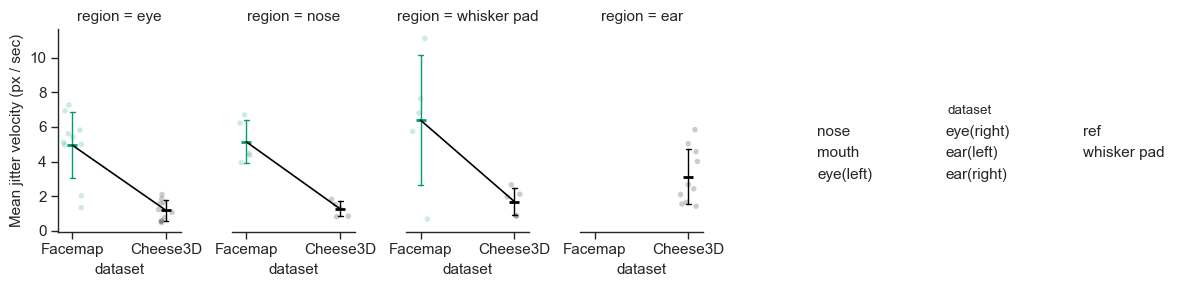

In [31]:
REGION_ORDER_v2 = ["eye", "nose", "whisker pad", "mouth", "ear"]
sub_df = avg_panview_df.dropna(axis=0)
sub_df = sort_by_region(sub_df, REGION_ORDER_v2, "dataset", asc = True)

def plot_2d_vs_2dproj(dataset, region, velocity, color, label):
    xs = dataset.values
    ys = velocity.values
    _region = region.unique()[0]
    all_ys = []
    for d in dataset.unique():
        _ys = ys[xs == d]
        all_ys.append(_ys)
    xs = np.repeat(dataset.unique(), [len(y) for y in all_ys])
    colors = [sns.color_palette("colorblind")[2] if dxs == 'Facemap' else 'black' for dxs in xs]
    ys = np.concatenate(all_ys, axis=0)
    sns.stripplot(x=xs, y=ys,
                #   color=centers_cmap[_region],
                  palette = colors,
                  dodge=True,
                  alpha=0.2,
                  size=4)
    xs = dataset.values
    colors = [sns.color_palette("colorblind")[2] if dxs == 'Facemap' else 'black' for dxs in xs]
    ys = velocity.values
    sns.pointplot(x=xs, y=ys,
                  errorbar=(lambda x: (x.mean() - x.std(ddof=1),
                                       x.mean() + x.std(ddof=1))),
                  capsize=0.05,
                  linewidth=1,
                  marker="_", markersize=7.5, markeredgewidth=2,
                #   color=centers_cmap[_region],
                  palette = colors,
                  label=label)

g = sns.FacetGrid(sub_df.query("region != 'mouth'"),
                  col="region", hue="dataset",
                  hue_order=['Facemap', 'Post-triangulation 2D'],
                  aspect=0.65,
                  margin_titles=True)
g.map(plot_2d_vs_2dproj, "dataset", "region", "mean_region_velocity_panview")
g.add_legend(label_order=list(centers_cmap.keys()), ncols=3)
# # g.figure.suptitle("Coordinate-wise Deviadtion from Mean Landmark Position")
g.set_xticklabels(["Facemap", "Cheese3D"])
g.set_ylabels("Mean jitter velocity (px / sec)")
g.tight_layout(h_pad=0.01, w_pad = 2.5)
REGION_ORDER_v2 = ["eye", "nose", "whisker pad", "mouth", "ear"]
regions = [r for r in REGION_ORDER_v2 if r!= 'mouth']
for col, ax in enumerate(g.axes.flat):
    if col < 5:
        r = regions[col]
        ys_0 = np.mean(sub_df.query("dataset == 'Post-triangulation 2D' & region == @r")['mean_region_velocity_panview'].values)
        ys_1 = np.mean(sub_df.query("dataset == 'Facemap' & region == @r")['mean_region_velocity_panview'].values)
        sns.lineplot(x = [1, 0], y = [ys_0, ys_1], color = 'black', ax = ax, legend=False)
        print(r, '\nCheese3D: ', ys_0, '\nFacemap', ys_1)
    if col > 0:
        sns.despine(ax=ax, left=True)
        ax.tick_params(axis="y", left=False)

fname = "f-keypoint-jitter-summary-2Dreproj-vs-facemap-per-region-Jan29"
g.figure.savefig(os.sep.join([OUTPUT_DIR, f"{fname}.svg"]), bbox_inches="tight")

### statistics

In [32]:
for col, ax in enumerate(g.axes.flat):
    r = regions[col]
    print(sub_df.query("region == @r")[["dataset", "mouse", "region_side", "mean_region_velocity_panview"]])


                  dataset mouse region_side  mean_region_velocity_panview
4                 Facemap   B20   eye(left)                      5.113117
6                 Facemap   B20  eye(right)                      1.332263
18                Facemap    B8   eye(left)                      7.266431
20                Facemap    B8  eye(right)                      4.986602
32                Facemap   B26   eye(left)                      4.959845
34                Facemap   B26  eye(right)                      2.025582
46                Facemap   B15   eye(left)                      5.819806
48                Facemap   B15  eye(right)                      5.602577
60                Facemap    B6   eye(left)                      6.933046
62                Facemap    B6  eye(right)                      5.406805
5   Post-triangulation 2D   B20   eye(left)                      0.747347
7   Post-triangulation 2D   B20  eye(right)                      0.565849
19  Post-triangulation 2D    B8   eye(

In [33]:
common_v = {} 
common_view_keypoints = []
for mouse in set(avg_sub_df['mouse']):
    for r in set(avg_sub_df['region']):
        # Exclude regions that are not in both Cheese3D and Facemap views (except the ears)
        # i.e., do not include views where keypoints are NaN 
        v_list_c3d = list(avg_sub_df.query("dataset == 'Post-triangulation 2D' & mouse == @m & "
                                           "region == @r & mean_region_velocity >= 0")['view'])
        v_list_fm = list(avg_sub_df.query("dataset == 'Facemap' & mouse == @m & "
                                          "region == @r & mean_region_velocity >= 0")['view'])
        if 'ear' not in r and sorted(v_list_c3d) != sorted(v_list_fm):
            v_list = [v for v in v_list_c3d if v in v_list_fm]
        else:
            v_list = v_list_c3d #should be equivalent to v_list_fm
        #Exclude mouth in BC view because Facemap is not reliable - updte: it is better now (Jan 16)
        # if r == 'mouth': 
        #     v_list = [v for v in v_list if v != 'BC'] 
        if len(common_v) < len(set(avg_sub_df["region"])):
            common_v[r] = v_list #Save on a dictionary the common views for each region
        for ds in set(avg_sub_df['dataset']):
            for v in v_list:
                for kp in set(jitter_df_2d.query("dataset == @ds & view == @v & region == @r")["landmark"]):
                    region_name = r.split('(')[0] if r in ['eye(left)', 'eye(right)', 'ear(left)', 'ear(right)'] else r
                    common_view_keypoints.append([ds, mouse, region_name, r, v, kp,
                                                  jitter_df_2d.query("dataset == @ds & mouse == @mouse & "
                                                                     "coordinate == 'vector' &"
                                                                     "landmark == @kp & view == @v")["mean_velocity"].values[0]])
jitter_common_df_2d = pd.DataFrame(common_view_keypoints, columns=["dataset",
                                                                "mouse",
                                                                "region",
                                                                "region_side",
                                                                "view",
                                                                "landmark",
                                                                "mean_velocity"])

In [34]:
for rgn in REGION_ORDER_v2:
    if rgn in ['ear', 'mouth']:
        continue
    # views = common_v[rgn] if rgn != 'eye' else common_v[f'{rgn}(right)'] + common_v[f'{rgn}(left)'] #Use only the views where the region shows in Facemap and C3D
    print(rgn)
    if rgn == 'mouth': #Note there is a different number of mouth keypoints in the common views thus I am just choosing lowerlip
        fm_mean = jitter_df_2d.query("dataset == 'Facemap' & landmark == 'lowerlip' & coordinate == 'vector' & view in @views")["mean_velocity"].values
        c3d_mean = jitter_df_2d.query("dataset == 'Post-triangulation 2D' & landmark == 'lowerlip' & coordinate == 'vector' & view in @views")["mean_velocity"].values
    else:
        fm_mean = jitter_common_df_2d.query("dataset == 'Facemap' & region == @rgn")["mean_velocity"].values
        c3d_mean = jitter_common_df_2d.query("dataset == 'Post-triangulation 2D' & region == @rgn")["mean_velocity"].values
        # print(list(jitter_df_2d.query("dataset == 'Facemap' & region == @rgn & coordinate == 'vector' & view in @views")["landmark"]) == list(jitter_df_2d.query("dataset == 'Post-triangulation 2D' & region == @rgn & coordinate == 'vector' & view in @views")["landmark"]))
    # print('Facemap', len(fm_mean), 'Cheese3D', len(c3d_mean))
    # print(set(jitter_df_2d.query("dataset == 'Facemap' & region == @rgn & coordinate == 'vector' & view in @views")["landmark"]))
    stat, pval = wilcoxon(fm_mean, c3d_mean, alternative="greater")
    print('p = ', pval)

eye
p =  2.0696869543572095e-18
nose
p =  5.84502068290484e-16
whisker pad
p =  0.00335693359375
